### Generate some statistics files

In [1]:
import analysis.stats_utils_v2 as stats_utils
from analysis.viz_utils_v2 import visualizer
import os
from tqdm import tqdm
# change here
exp_repo = "/home/zhijie/terasim/TeraSim-NDE-ITE/output"
mode="cosim_test_local"
# user = "zhijie"
experiment_record_repo = f"{exp_repo}/{mode}/raw_data"
export_stat_dir = f"{exp_repo}/{mode}/processed_data"

if not os.path.exists(export_stat_dir):
    os.system(f"mkdir -p {export_stat_dir}")
    os.system(f"chmod 755 {export_stat_dir}")

In [2]:
stats_utils.export_to_csv_aws(experiment_record_repo, export_stat_dir)
os.system(f"chmod -R 775 {export_stat_dir}")

100%|██████████| 1/1 [00:00<00:00, 1582.76it/s]


  0%|          | 0/115 [00:00<?, ?it/s]

0

In [3]:
awk_cmd = """awk -F "[_/]" '{print $35}'""" + " check.txt | sort | uniq -cd"
print("count", "exp_id")
os.system(awk_cmd)

count exp_id


0

### Analyze

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#### Import statistics of each experiment

In [5]:
exp_stats_info = pd.read_csv(f"{export_stat_dir}/stats.tsv", sep='\t')
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1187.7,NaN,NaN,-0.061107,14,NaN,-1.0,NaN,NaN,56822.427343,2122.552416,NaN,NaN,NaN,None,-10.0,NaN
1,cosim_test_local_0_2,1233.6,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,60077.989927,499.009403,NaN,NaN,NaN,None,-10.0,NaN
2,cosim_test_local_0_3,1299.0,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,70258.957650,5843.751890,NaN,NaN,NaN,None,-10.0,NaN
3,cosim_test_local_0_4,1497.8,NaN,NaN,-0.021824,5,NaN,-1.0,NaN,NaN,123840.562385,7096.644339,NaN,NaN,NaN,None,-10.0,NaN
4,cosim_test_local_0_5,1182.7,NaN,NaN,-0.030553,7,NaN,-1.0,NaN,NaN,48069.779738,3235.461599,NaN,NaN,NaN,None,-10.0,NaN


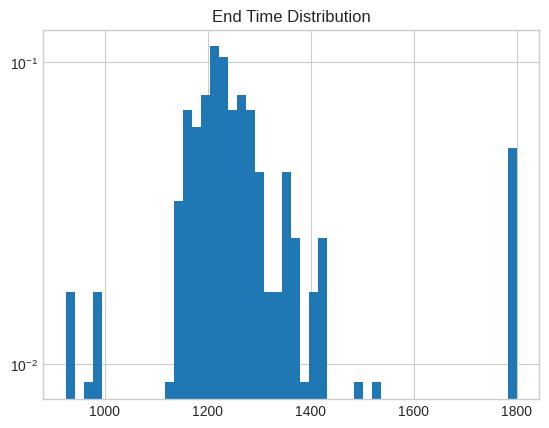

In [6]:
# draw the end time distribution
# exp_stats_info["end_time"].hist(bins=100)
num_experiments = len(exp_stats_info)
plt.hist(exp_stats_info["end_time"], weights=np.ones(num_experiments)/num_experiments, bins=50)
plt.yscale("log")
plt.title("End Time Distribution")
plt.savefig(f"{export_stat_dir}/end_time.png")

**Filter the experiments with time difference between negligence and collision larger than 3s**

In [7]:
warm_up_time = 900
estimated_end_time = warm_up_time + 300

has_collision = (exp_stats_info['crash_veh_1'] == "CAV") | (exp_stats_info['crash_veh_2'] == "CAV")
collision_df = exp_stats_info[has_collision]

has_collision_in_warmup = (exp_stats_info['end_time'] <= warm_up_time)
warmup_collision_df = exp_stats_info[has_collision_in_warmup]

print("Collision numbers:", len(collision_df), "Warmup collisions:", len(warmup_collision_df)) # the number of collisions 

Collision numbers: 7 Warmup collisions: 0


**See the list of files with time difference between negligence and collision larger than 3s**

### See the collisions

In [8]:
collision_df.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
17,cosim_test_local_0_18,1243.9,BV_13.11,CAV,-0.017459,4,CAV,-1.0,NaN,NaN,66288.047210,3225.998615,EG_14_2_1_0,rear_end,intersection,0.5696479336721438,-0.015694,0.154855
20,cosim_test_local_0_21,961.0,BV_8.42,CAV,4.979163,3,CAV,-1.0,NaN,NaN,5813.957448,174.036363,:nd_34_1_6_0_0,sideswipe,roundabout_1,4.98310494199427,-3.745406,2.965956
33,cosim_test_local_0_34,987.9,BV_8.42,CAV,-0.000000,0,CAV,-1.0,NaN,NaN,20977.299331,1831.807844,:nd_34_1_6_0_0,rear_end,roundabout_1,0.5910658820428125,-0.508871,1.708120
84,cosim_test_local_0_85,980.5,BV_8.51,CAV,-0.000000,0,CAV,-1.0,NaN,NaN,17423.940952,1139.674866,:nd_34_1_6_0_0,rear_end,roundabout_1,0.7086582403831585,-0.309803,1.582551
87,cosim_test_local_0_88,924.6,BV_8.65,CAV,5.115528,21,BV_8.65,0.6,LeftFoll,highway_cutin,4619.121796,0.000000,EG_1_3_1_1,sideswipe,freeway_1,17.039962474469462,-1.861244,3.064589


In [9]:
all_maneuvers = exp_stats_info["maneuver_challenge"].sum()
all_time = (exp_stats_info["end_time"] - 900).sum()
all_routes = np.load(f"{export_stat_dir}/cav_traveling_distance_list.npy").sum()
mile_to_m = 1609.344
no_negligence_collision_related = collision_df['neg_time_diff'] < 0
power_importance_weight = np.power(10, - exp_stats_info['importance'])
collide_importance_weight = power_importance_weight[has_collision]
importance_all = collide_importance_weight.sum()
num_experiments = len(exp_stats_info)
num_collisions = len(collision_df)
no_related_negligence_collision = collision_df[no_negligence_collision_related]

print(f"Number of experiments: {num_experiments}")
print(f"Number of collision: {num_collisions}")
# print(f"Collisions with weight less than 1: {len(collide_importance_weight)}")
print(f"Importance summation: {importance_all}")
print(f"Max weight: {collide_importance_weight.max()}, Min weight: {collide_importance_weight.min()}")
print(f"raw collision rate: {num_collisions / num_experiments}")
print(f"adjusted collision rate (importance): {importance_all/num_experiments}")
print(f"Collision due to traffic light ignorance: {len(collision_df[collision_df['neg_reason'] == 'TFL'])}")
print(f"Overall maneuvers: {all_maneuvers}")

print(f"Collision without negligence: {len(no_related_negligence_collision)}")
print(f"Maximum time between collision and negligence: {collision_df['neg_time_diff'].max():.2f} s")

print()
print(f"Overall time: {all_time:.2f} s")
print(f"Maneuvers per second: {all_maneuvers / all_time}")
print(f"Overall route length: {all_routes:.2f} m")
print(f"m/s: {all_routes/all_time}")
print(f"Overall route length: {all_routes/mile_to_m} mile")
print(f"mile/s: {all_routes/mile_to_m/all_time} mile/s")
print(f"Crash per mile: {importance_all/all_routes*mile_to_m} crash/mile")

FileNotFoundError: [Errno 2] No such file or directory: '/home/zhijie/terasim/TeraSim-NDE-ITE/output/cosim_test_local/processed_data/cav_traveling_distance_list.npy'

In [ ]:
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1228.8,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,64017.752143,3838.817885,NaN,NaN,NaN,None,-10.000000,NaN
1,cosim_test_local_0_2,1165.3,NaN,NaN,-0.021824,5,NaN,-1.0,NaN,NaN,46070.858546,4352.696713,NaN,NaN,NaN,None,-10.000000,NaN
2,cosim_test_local_0_3,959.2,BV_17.44,CAV,-0.000000,0,CAV,-1.0,NaN,NaN,11918.040881,191.105150,EG_1_3_1_1,rear_end,freeway_1,0.07643575501914768,-0.043238,4.264137
3,cosim_test_local_0_4,1219.3,NaN,NaN,-0.034918,8,NaN,-1.0,NaN,NaN,57114.165161,3134.269448,NaN,NaN,NaN,None,-10.000000,NaN
4,cosim_test_local_0_5,1300.9,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,74768.547880,1104.191156,NaN,NaN,NaN,None,-10.000000,NaN


In [10]:
a = exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200)]
a

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1187.7,NaN,NaN,-0.061107,14,NaN,-1.0,NaN,NaN,56822.427343,2122.552416,NaN,NaN,NaN,None,-10.000000,NaN
4,cosim_test_local_0_5,1182.7,NaN,NaN,-0.030553,7,NaN,-1.0,NaN,NaN,48069.779738,3235.461599,NaN,NaN,NaN,None,-10.000000,NaN
8,cosim_test_local_0_9,1190.6,NaN,NaN,-0.008730,2,NaN,-1.0,NaN,NaN,56751.641285,2554.504893,NaN,NaN,NaN,None,-10.000000,NaN
21,cosim_test_local_0_22,1188.3,NaN,NaN,-0.218239,50,NaN,-1.0,NaN,NaN,54718.615418,3660.989138,NaN,NaN,NaN,None,-10.000000,NaN
23,cosim_test_local_0_24,1169.1,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,55148.744231,5116.273214,NaN,NaN,NaN,None,-10.000000,NaN
28,cosim_test_local_0_29,1172.2,NaN,NaN,-0.008729,2,NaN,-1.0,NaN,NaN,49438.975235,718.317760,NaN,NaN,NaN,None,-10.000000,NaN
32,cosim_test_local_0_33,1152.6,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,44901.492224,3209.898666,NaN,NaN,NaN,None,-10.000000,NaN
33,cosim_test_local_0_34,987.9,BV_8.42,CAV,-0.000000,0,CAV,-1.0,NaN,NaN,20977.299331,1831.807844,:nd_34_1_6_0_0,rear_end,roundabout_1,0.5910658820428125,-0.508871,1.708120
34,cosim_test_local_0_35,1197.5,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,71413.731337,4355.305371,NaN,NaN,NaN,None,-10.000000,NaN
42,cosim_test_local_0_43,1160.1,NaN,NaN,-0.017458,4,NaN,-1.0,NaN,NaN,51675.677469,3471.321348,NaN,NaN,NaN,None,-10.000000,NaN


### Crash Distribution (with negligence)

In [11]:
exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200) & (exp_stats_info["neg_time_diff"]  > 0)]

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity


### Load file that show the relationship between lane and experiment

**See the collision number in each experiment**

In [12]:
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1187.7,NaN,NaN,-0.061107,14,NaN,-1.0,NaN,NaN,56822.427343,2122.552416,NaN,NaN,NaN,None,-10.0,NaN
1,cosim_test_local_0_2,1233.6,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,60077.989927,499.009403,NaN,NaN,NaN,None,-10.0,NaN
2,cosim_test_local_0_3,1299.0,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,70258.957650,5843.751890,NaN,NaN,NaN,None,-10.0,NaN
3,cosim_test_local_0_4,1497.8,NaN,NaN,-0.021824,5,NaN,-1.0,NaN,NaN,123840.562385,7096.644339,NaN,NaN,NaN,None,-10.0,NaN
4,cosim_test_local_0_5,1182.7,NaN,NaN,-0.030553,7,NaN,-1.0,NaN,NaN,48069.779738,3235.461599,NaN,NaN,NaN,None,-10.0,NaN


In [13]:
# collision: negligence-caused no negligence caused (SUMO)
neg_caused_collision = exp_stats_info[exp_stats_info["neg_time_diff"] >= 0 & has_collision] # weight < 1 collisions
no_neg_realated_collision = exp_stats_info[(exp_stats_info["neg_time_diff"] < 0) & has_collision]
print(len(neg_caused_collision), len(no_neg_realated_collision))
print(len(exp_stats_info[has_collision]))

3 4
7


Negligence caused distribution

In [14]:
neg_caused_collision["lane_id"].value_counts()
# print(len(neg_caused_collision))

EG_1_3_1_1     2
EG_14_2_1_0    1
Name: lane_id, dtype: int64

No negligence caused distribution

In [15]:
print(no_neg_realated_collision["lane_id"].value_counts())
print(len(no_neg_realated_collision))

:nd_34_1_6_0_0    3
EG_14_2_1_0       1
Name: lane_id, dtype: int64
4


### Crash Distribution (All)

In [16]:
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,cosim_test_local_0_1,1187.7,NaN,NaN,-0.061107,14,NaN,-1.0,NaN,NaN,56822.427343,2122.552416,NaN,NaN,NaN,None,-10.0,NaN
1,cosim_test_local_0_2,1233.6,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,60077.989927,499.009403,NaN,NaN,NaN,None,-10.0,NaN
2,cosim_test_local_0_3,1299.0,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,70258.957650,5843.751890,NaN,NaN,NaN,None,-10.0,NaN
3,cosim_test_local_0_4,1497.8,NaN,NaN,-0.021824,5,NaN,-1.0,NaN,NaN,123840.562385,7096.644339,NaN,NaN,NaN,None,-10.0,NaN
4,cosim_test_local_0_5,1182.7,NaN,NaN,-0.030553,7,NaN,-1.0,NaN,NaN,48069.779738,3235.461599,NaN,NaN,NaN,None,-10.0,NaN


In [17]:
def crash_distribution(all_stats_info, feat_name):
    crash_type_dist = all_stats_info.groupby(["location", feat_name], as_index=False).agg(
        {
            "name": "count",
            "exp_importance": "sum"
        }
    )

    crash_type_dist["collision_rate"] = crash_type_dist["name"] / num_experiments
    crash_type_dist["importance_rate"] = crash_type_dist["exp_importance"] / num_experiments

    crash_type_dist.rename(columns={"name": "count"}, inplace=True)
    return crash_type_dist

In [18]:
all_stats_info = exp_stats_info.copy()[has_collision]
all_stats_info["exp_importance"] = np.power(10, -all_stats_info["importance"])

get_type_func = lambda x: x.split("_")[0] if x is not np.nan else "None"
all_stats_info["location"] = list(map(get_type_func, all_stats_info["location_type"]))
all_stats_info["collision"] = list(map(get_type_func, all_stats_info["collision_type"]))


crash_type_dist = crash_distribution(all_stats_info, "collision")
crash_type_dist

,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,sideswipe,2,0.000015,0.017391,1.275285e-07
1,intersection,rear,2,1.041077,0.017391,9.052845e-03
2,roundabout,rear,2,2.000000,0.017391,1.739130e-02
3,roundabout,sideswipe,1,0.000010,0.008696,9.123032e-08


In [19]:
print(all_stats_info)

                       name  end_time crash_veh_1 crash_veh_2  importance  \
17    cosim_test_local_0_18    1243.9    BV_13.11         CAV   -0.017459   
20    cosim_test_local_0_21     961.0     BV_8.42         CAV    4.979163   
33    cosim_test_local_0_34     987.9     BV_8.42         CAV   -0.000000   
84    cosim_test_local_0_85     980.5     BV_8.51         CAV   -0.000000   
87    cosim_test_local_0_88     924.6     BV_8.65         CAV    5.115528   
98    cosim_test_local_0_99    1129.4         CAV    BV_13.19    4.244129   
104  cosim_test_local_0_105     936.8     BV_8.36         CAV    5.154811   

     maneuver_challenge   neg_veh  neg_time_diff neg_reason  \
17                    4       CAV           -1.0        NaN   
20                    3       CAV           -1.0        NaN   
33                    0       CAV           -1.0        NaN   
84                    0       CAV           -1.0        NaN   
87                   21   BV_8.65            0.6   LeftFoll   
98   

In [20]:
# location_distribution = crash_type_dist.groupby("location").sum()
# proportion = location_distribution["exp_importance"]
# print(proportion)

# plt.figure(figsize=(20, 10))
# plt.subplot(3, 1, 1)
# plt.pie(proportion, labels=proportion.index, autopct='%1.1f%%')
# # plt.bar(proportion.index, values=proportion)
# plt.title("Autoware AI")
# plt.subplot(3, 1, 2)
# true_dist = np.array([1525, 4581, 307]) / (1525 + 4581 + 307)
# plt.pie(true_dist, labels=proportion.index, autopct='%1.1f%%')
# # plt.bar(proportion.index, values=true_dist)
# plt.title("ground truth")|

In [21]:
def pie_chart_plot(df, mode, feat_name,value_name="importance_rate"):
    mark = df["location"] == mode
    labels = df[mark][feat_name]
    values = df[mark][value_name]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    # plt.bar(labels, values)
    plt.title(f'{mode}')
    # plt.legend(labels)

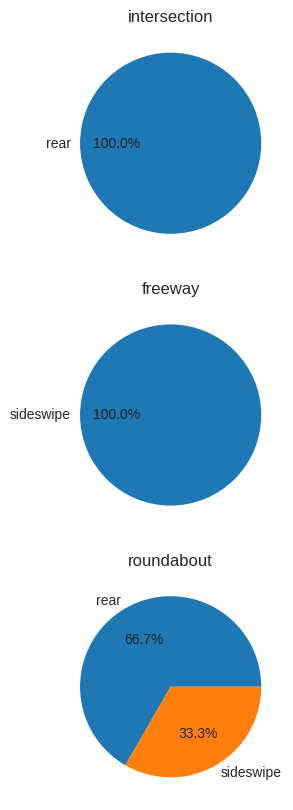

In [22]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision", "collision_rate")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision", "collision_rate")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision", "collision_rate")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

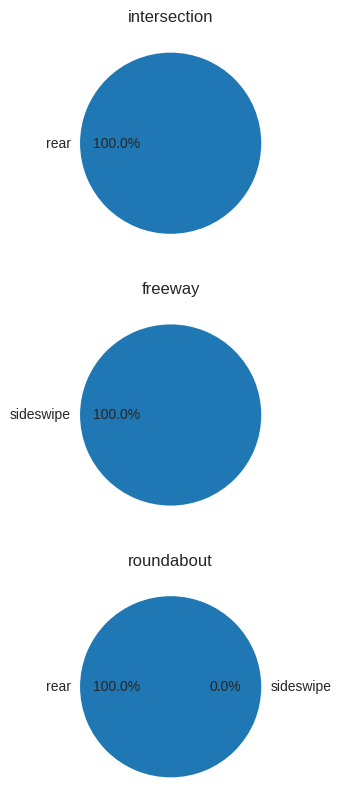

In [23]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

### Crash Severity Distribution

Text(0, 0.5, 'Count')

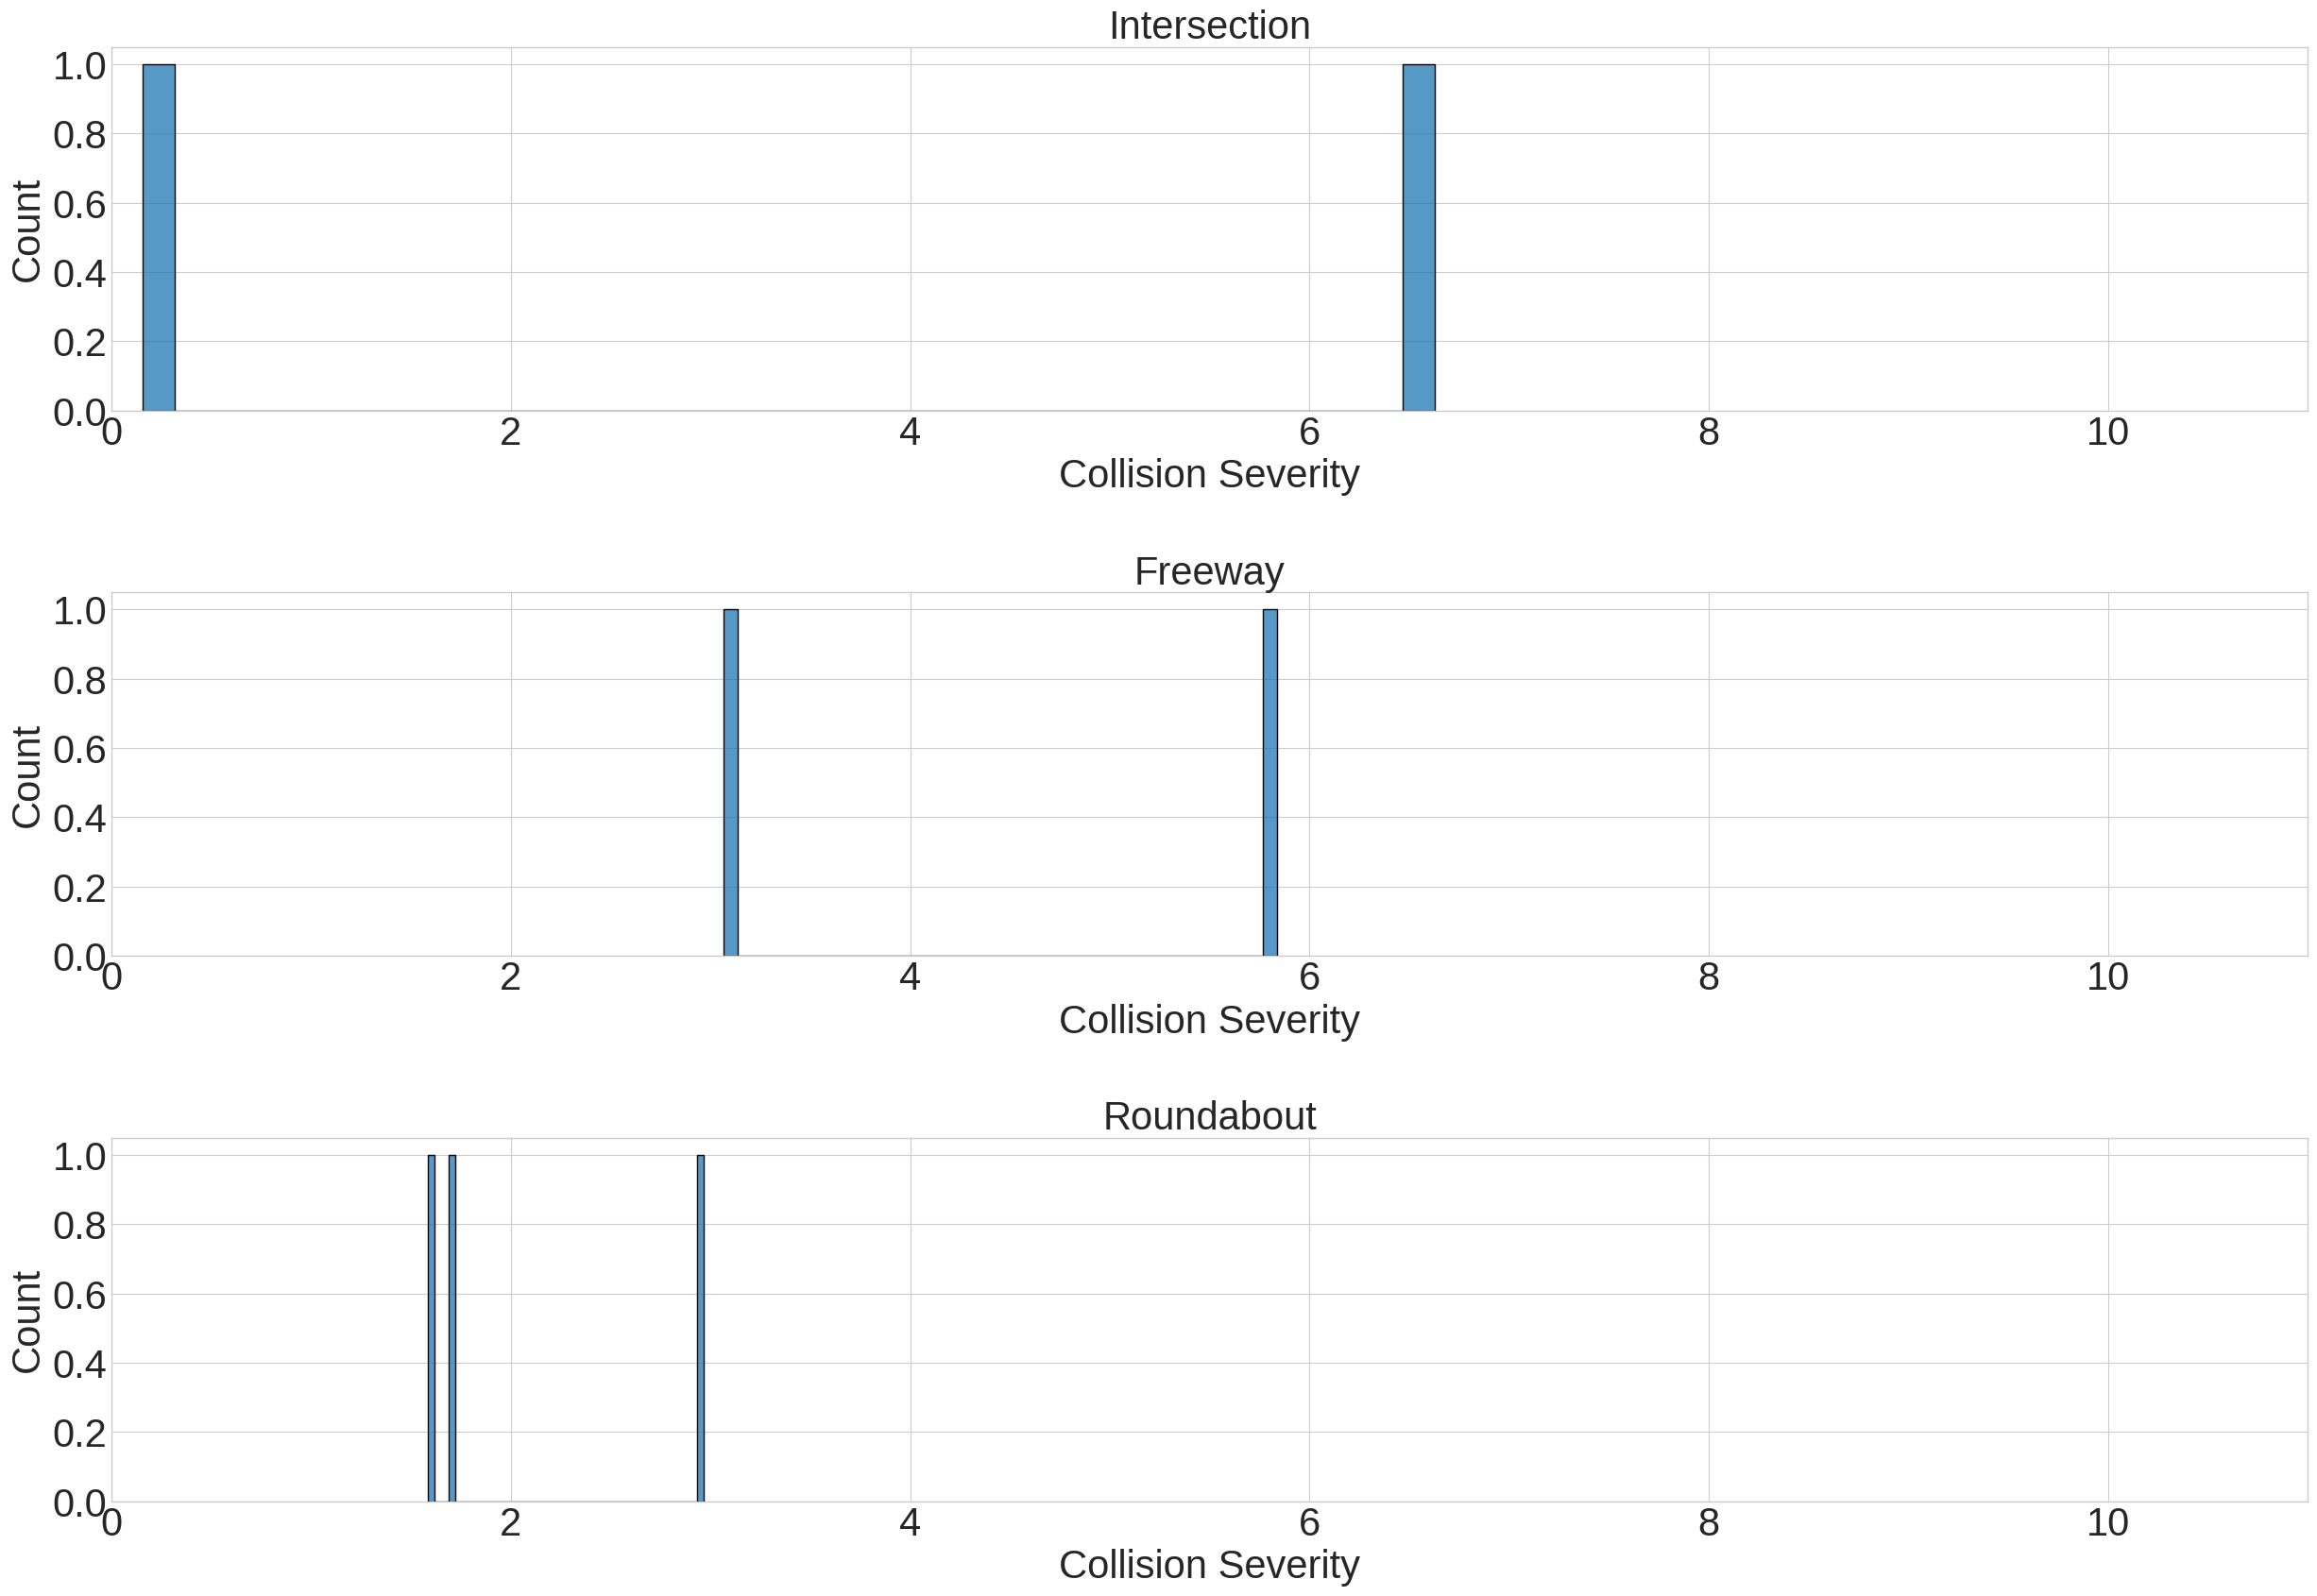

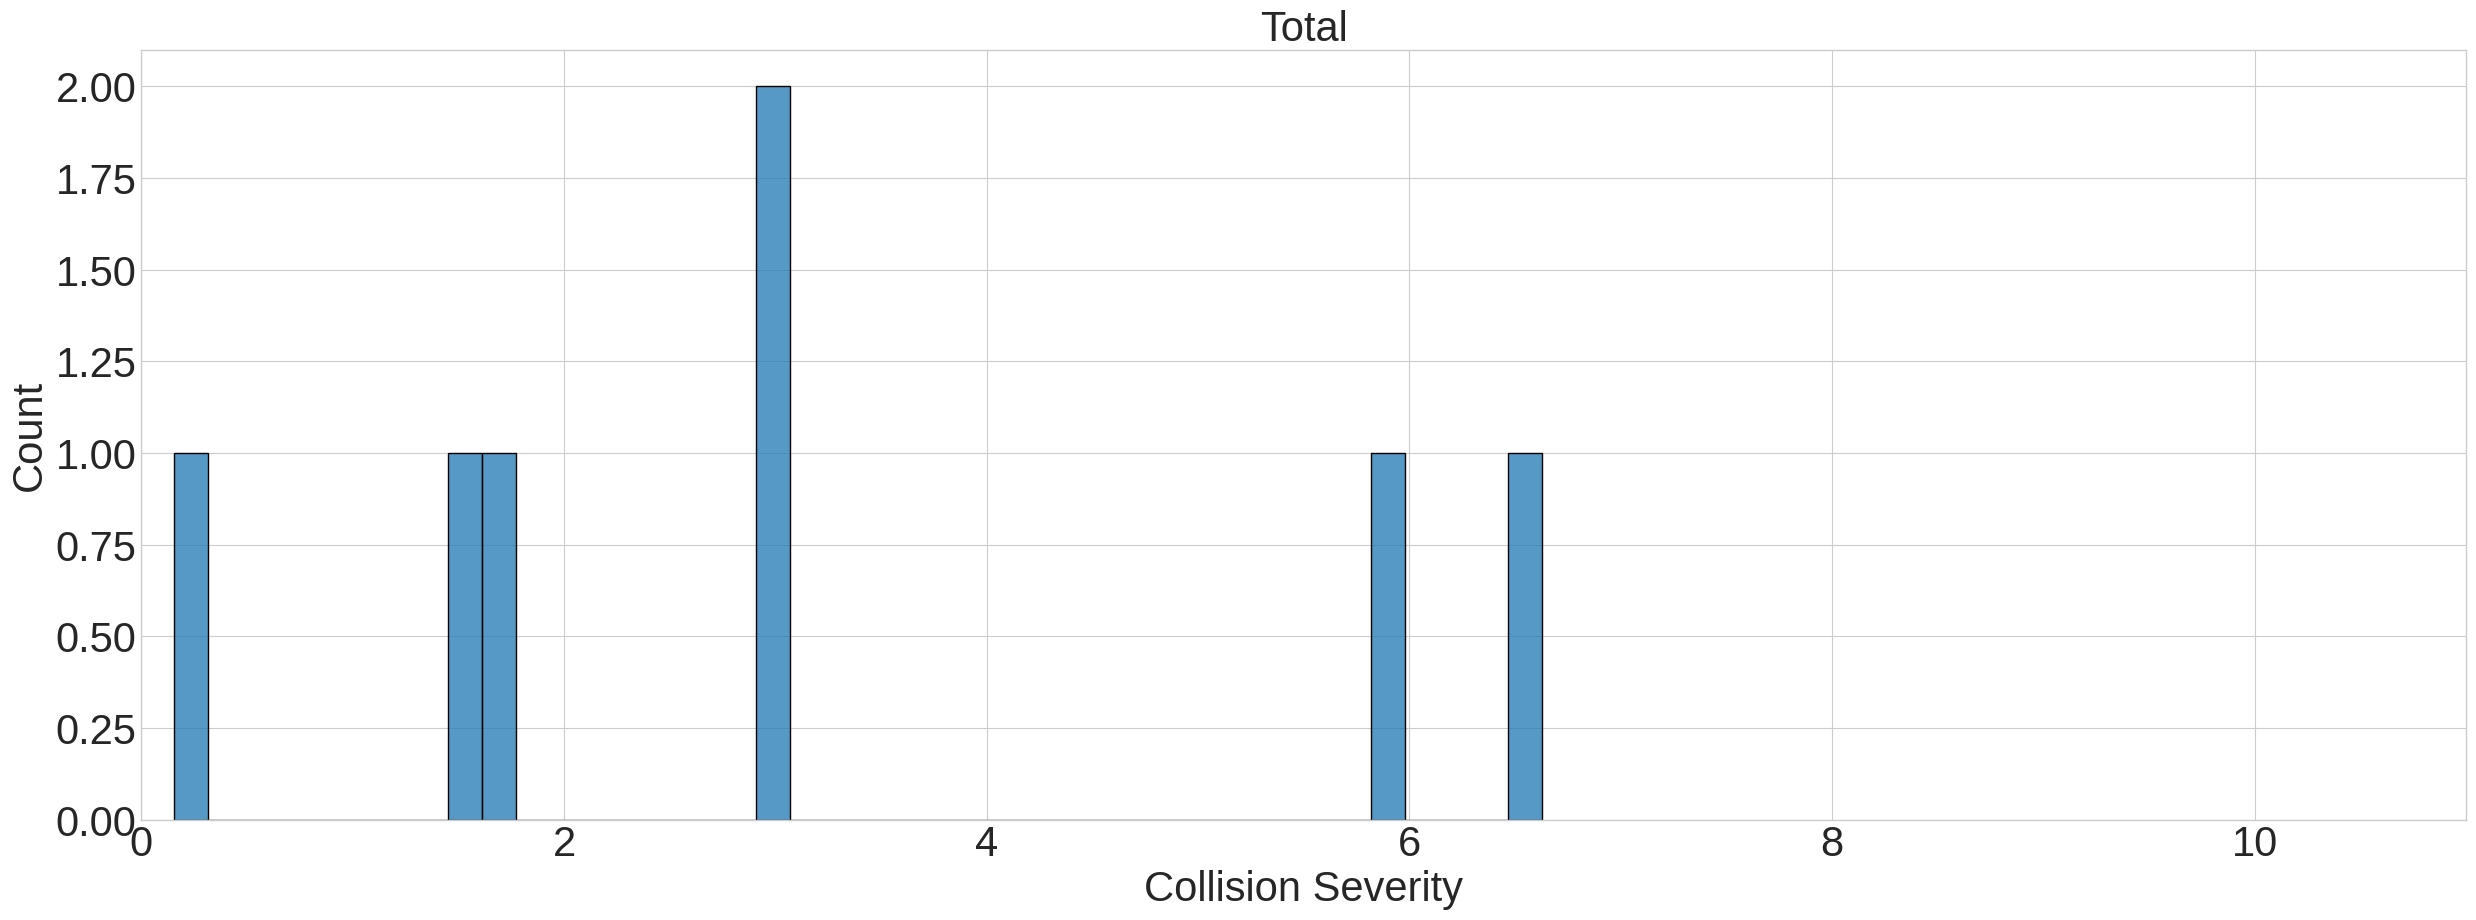

In [24]:
import seaborn as sns

# plot histogram of collision severity
plt.figure(figsize=(30, 20))
plt.subplot(3, 1, 1)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "intersection"], x="collision_severity", bins=40)
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Intersection", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 1, 2)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "freeway"], x="collision_severity", bins=40)
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Freeway", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 1, 3)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "roundabout"], x="collision_severity", bins=40)
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Roundabout", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)

# plot histogram of collision severity in total
plt.figure(figsize=(30, 10))
sns.histplot(data=all_stats_info, x="collision_severity", bins=40)
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Total", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Count", fontsize=30)

Text(0, 0.5, 'Weighted Count')

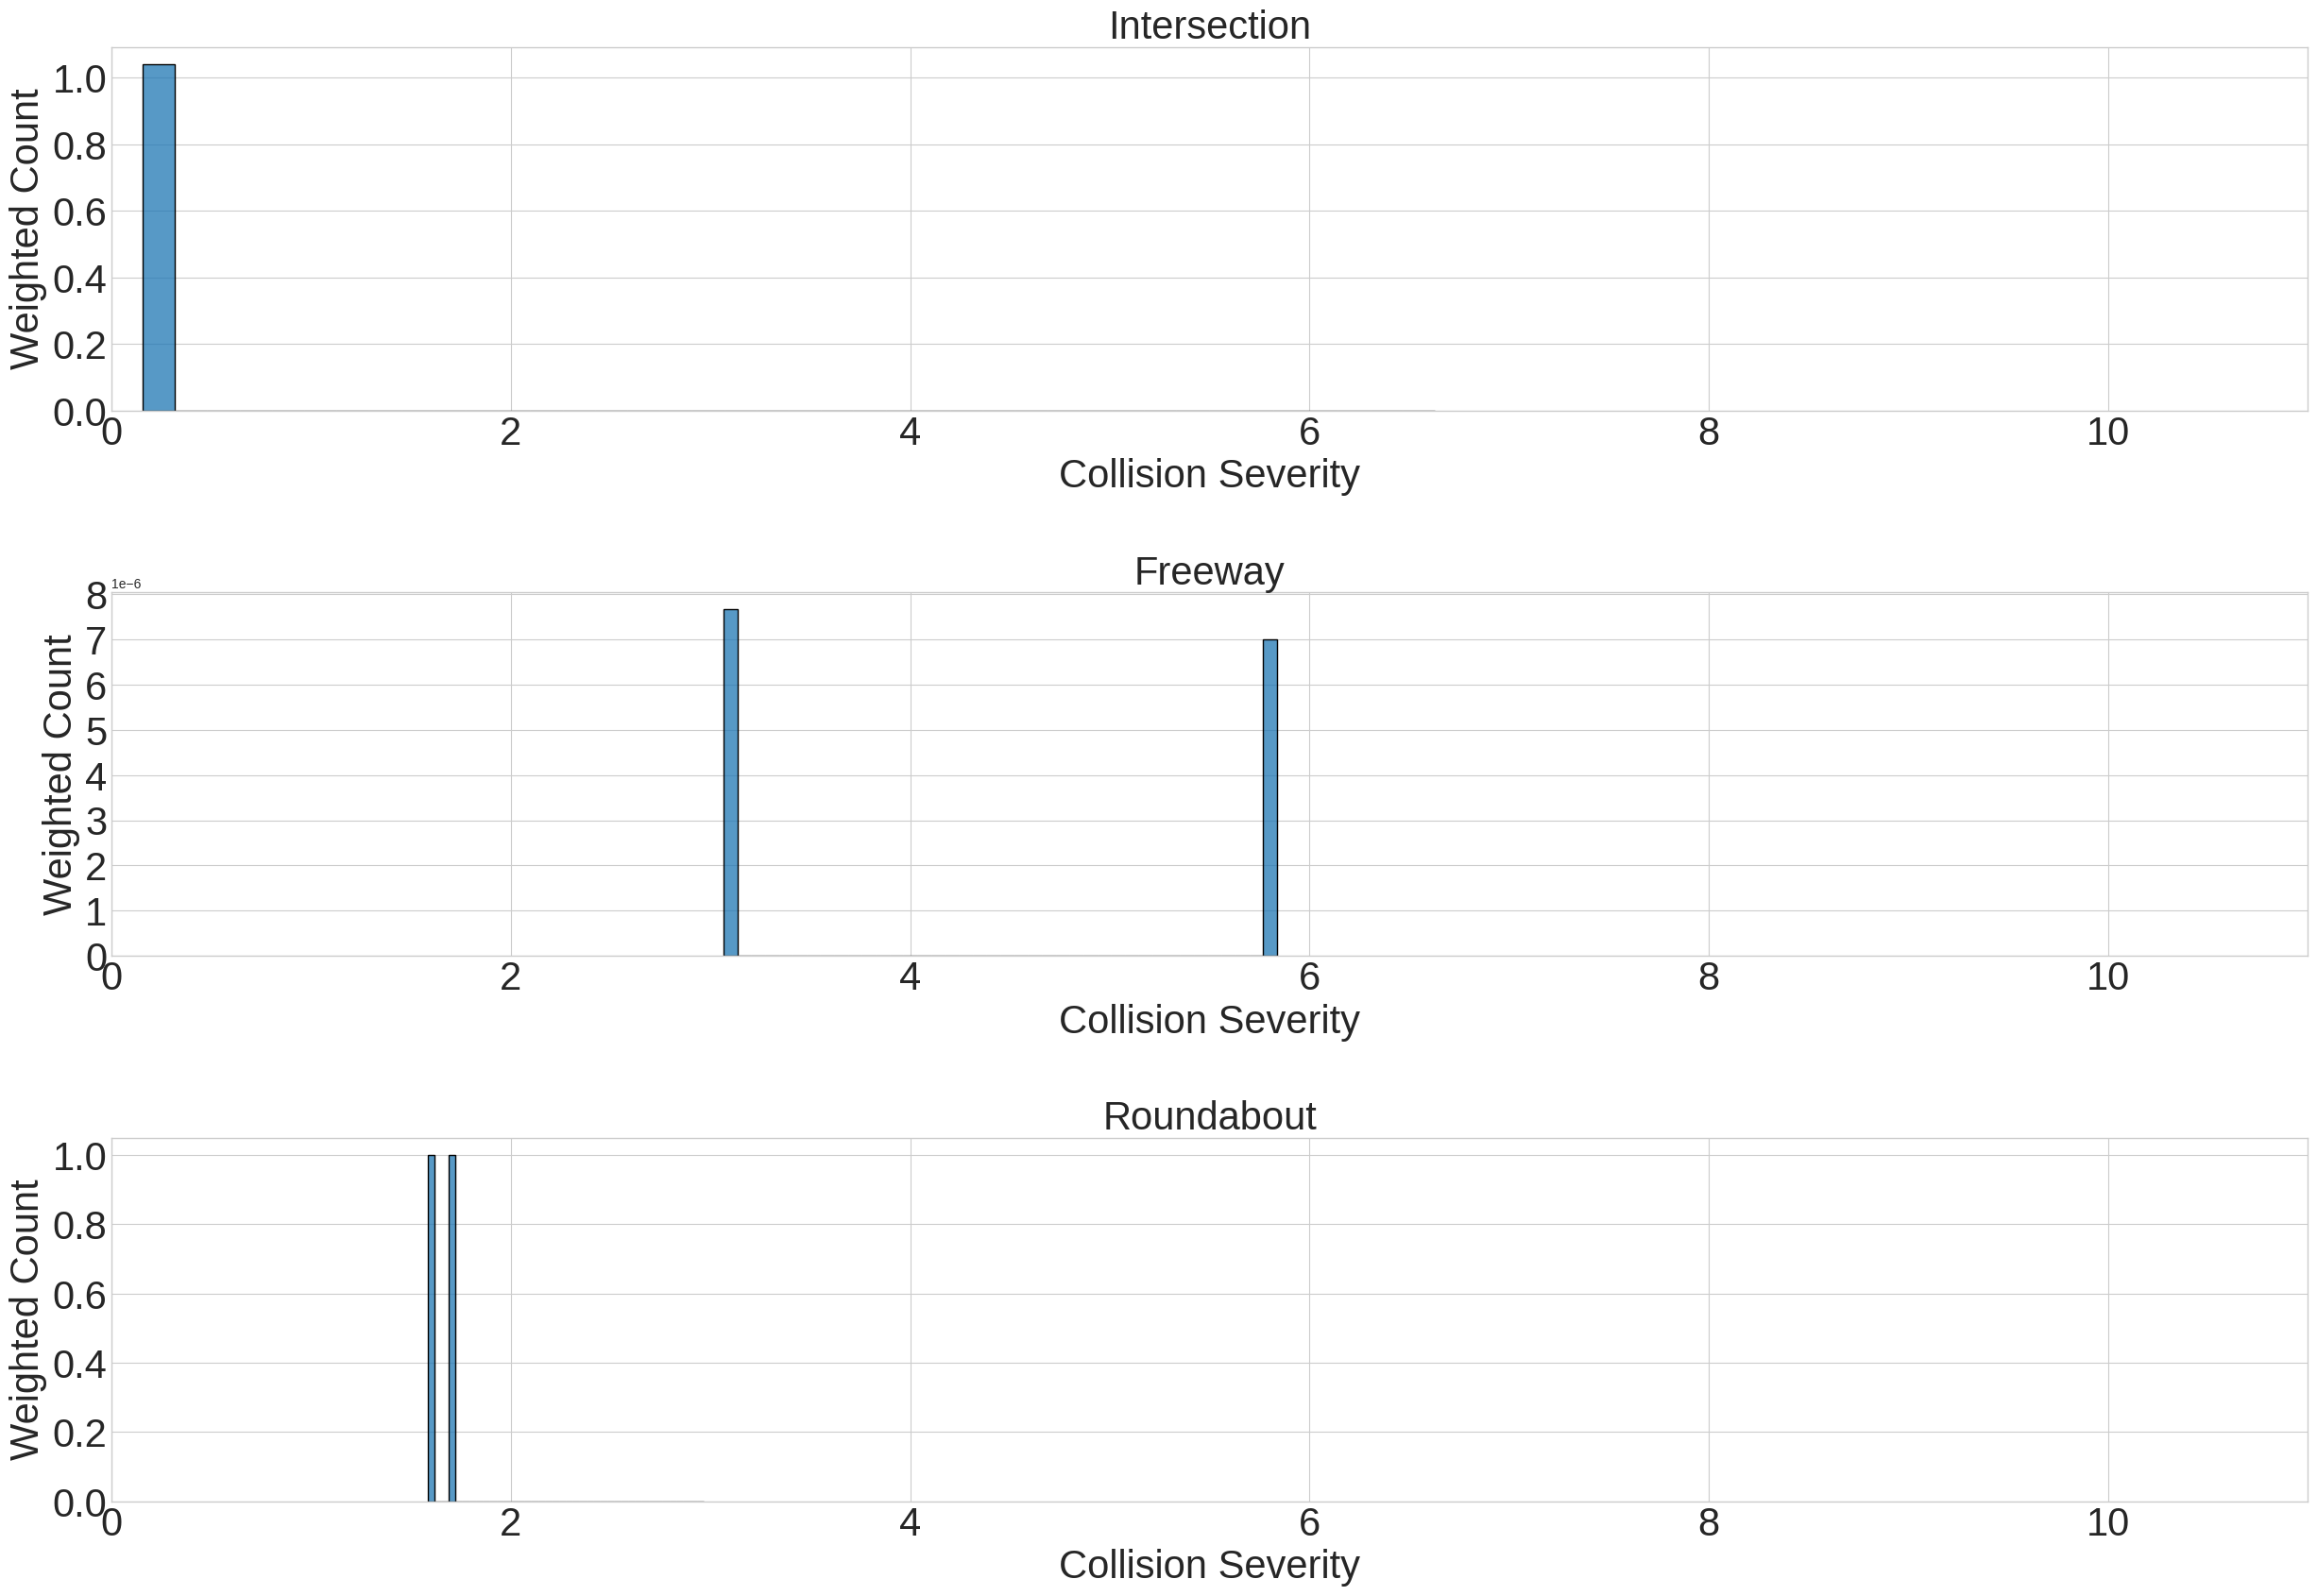

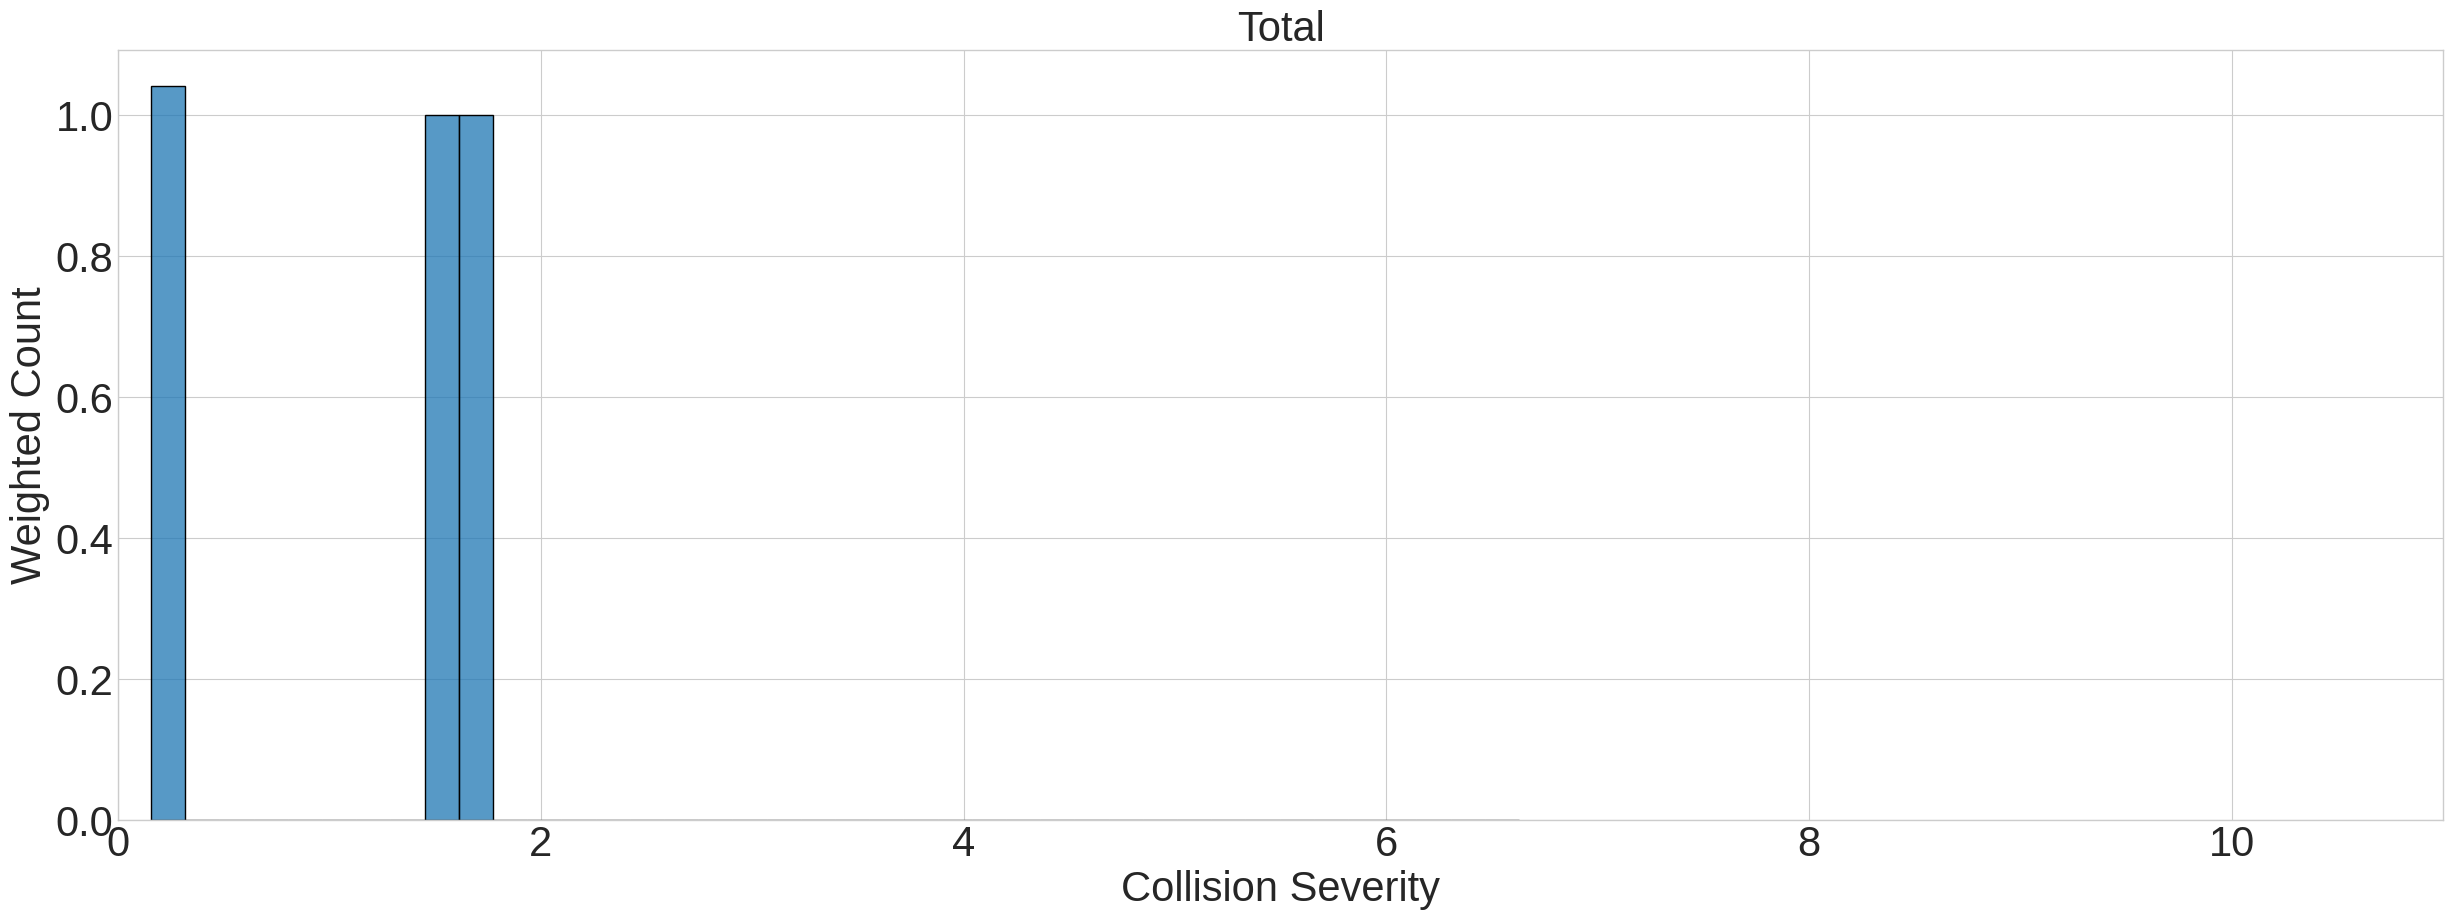

In [25]:
import seaborn as sns
all_stats_info
# plot histogram of collision severity
plt.figure(figsize=(30, 20))
plt.subplot(3, 1, 1)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "intersection"], x="collision_severity", bins=40, weights=all_stats_info[all_stats_info["location"] == "intersection"]["exp_importance"])
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Intersection", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Weighted Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 1, 2)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "freeway"], x="collision_severity", bins=40, weights=all_stats_info[all_stats_info["location"] == "freeway"]["exp_importance"])
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Freeway", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Weighted Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 1, 3)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "roundabout"], x="collision_severity", bins=40, weights=all_stats_info[all_stats_info["location"] == "roundabout"]["exp_importance"])
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Roundabout", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Weighted Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)

# plot histogram of collision severity in total
plt.figure(figsize=(30, 10))
sns.histplot(data=all_stats_info, x="collision_severity", bins=40, weights=all_stats_info["exp_importance"])
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Total", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Weighted Count", fontsize=30)

## Near Miss Analysis

In [26]:
from pathlib import Path
distance_list_dir = Path(export_stat_dir) / "distance_list.npy"
ttc_list_dir = Path(export_stat_dir) / "ttc_list.npy"
# check if the file exists
if not os.path.exists(distance_list_dir) or not os.path.exists(ttc_list_dir):
    print(export_stat_dir)
    print("Near Miss Data not found, please run the following command to generate the data")
else:
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    distance_list = np.load(distance_list_dir)
    ttc_list = np.load(ttc_list_dir)
    plt.figure(figsize=(30, 10))
    sns.histplot(data=distance_list, bins=100)
    plt.title("Distance Distribution", fontsize=30)
    plt.xlabel("Distance (m)", fontsize=30)
    plt.ylabel("Count", fontsize=30)
    plt.xlim(0, 10)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.savefig(f"{export_stat_dir}/distance_distribution.png")
    plt.figure(figsize=(30, 10))
    sns.histplot(data=ttc_list, bins=100)
    plt.title("TTC Distribution", fontsize=30)
    plt.xlabel("TTC (s)", fontsize=30)
    plt.ylabel("Count", fontsize=30)
    plt.xlim(0,5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.savefig(f"{export_stat_dir}/ttc_distribution.png")

/home/zhijie/terasim/TeraSim-NDE-ITE/output/cosim_test_local/processed_data
Near Miss Data not found, please run the following command to generate the data


### Quick check

In [27]:
quick_check_exp = no_neg_realated_collision.groupby("lane_id").agg({
    "name": ["nunique", "first"],
    # "veh_1_route": set,
    # "veh_2_route": set,
    # "experiment": "first"
})
# quick_check_exp["veh_route"] = quick_check_exp[["veh_1_route", "veh_2_route"]].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
quick_check_exp.sort_values(by=("name", "nunique"), ascending=False)

name                       
               nunique                  first
lane_id                                      
:nd_34_1_6_0_0       3  cosim_test_local_0_21
EG_14_2_1_0          1  cosim_test_local_0_18

#### Export the checklist

In [28]:
# simple checklist
quick_check_list_path = f"{export_stat_dir}/quick_check_list.txt"
neg_caused_check_list_path = f"{export_stat_dir}/neg_caused_check_list.txt"
non_neg_check_list_path = f"{export_stat_dir}/non_neg_check_list.txt"

with open(quick_check_list_path, "w") as f:
    print(*set(quick_check_exp[("name", "first")].values), sep="\n", file=f)
with open(neg_caused_check_list_path, "w") as f:
    print(*set(neg_caused_collision["name"].values), sep="\n", file=f)
with open(non_neg_check_list_path, "w") as f:
    print(*set(no_neg_realated_collision["name"].values), sep="\n", file=f)

### Generate videos in the check list

In [29]:
exp_stats_info["location"] = list(map(get_type_func, exp_stats_info["location_type"]))
exp_stats_info["collision"] = list(map(get_type_func, exp_stats_info["collision_type"]))

In [30]:
import pathlib
def get_location_collision_type(exp_id, exp_stats_info):
    mark = exp_stats_info["name"] == exp_id
    location_type = exp_stats_info[mark]["location"].values[0]
    collision_type = exp_stats_info[mark]["collision"].values[0]
    return location_type, collision_type

def export_videos(export_path, file_name, map_location="."):
    if not os.path.exists(export_path):
        os.system(f"mkdir -p {export_path}")
        os.system(f"chmod 755 {export_path}")
    with open(file_name) as f:
        for line in tqdm(f.readlines()): 
            experiment_record_repo = f"{exp_repo}/{mode}"
            exp_id = line.strip()
            # path_name = os.path.join(experiment_record_repo, exp_id)
            experiment_record_repo = pathlib.Path(experiment_record_repo)
            # locate the folder under experiment_record_repo with the name exp_id
            path_name = list(experiment_record_repo.glob(f"**/{exp_id}"))[0]
            if os.path.isdir(path_name):
                location_type, collision_type = get_location_collision_type(exp_id, exp_stats_info)
                # print(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                # location_type, collision_type = "None", 'None'
                if location_type == "None" or collision_type == "None":
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                else:
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, f"{location_type}/{collision_type}"))

  0%|          | 0/4 [00:00<?, ?it/s]/home/zhijie/terasim/TeraSim-NDE-ITE/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":


/home/zhijie/terasim/TeraSim-NDE-ITE/output/cosim_test_local/raw_data/final_state/cosim_test_local_0_final_state.json


 25%|██▌       | 1/4 [00:14<00:44, 14.86s/it]/home/zhijie/terasim/TeraSim-NDE-ITE/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":


/home/zhijie/terasim/TeraSim-NDE-ITE/output/cosim_test_local/raw_data/final_state/cosim_test_local_0_final_state.json


 50%|█████     | 2/4 [00:33<00:34, 17.12s/it]/home/zhijie/terasim/TeraSim-NDE-ITE/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":


/home/zhijie/terasim/TeraSim-NDE-ITE/output/cosim_test_local/raw_data/final_state/cosim_test_local_0_final_state.json


 75%|███████▌  | 3/4 [00:48<00:16, 16.31s/it]/home/zhijie/terasim/TeraSim-NDE-ITE/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":


/home/zhijie/terasim/TeraSim-NDE-ITE/output/cosim_test_local/raw_data/final_state/cosim_test_local_0_final_state.json


100%|██████████| 4/4 [01:05<00:00, 16.34s/it]


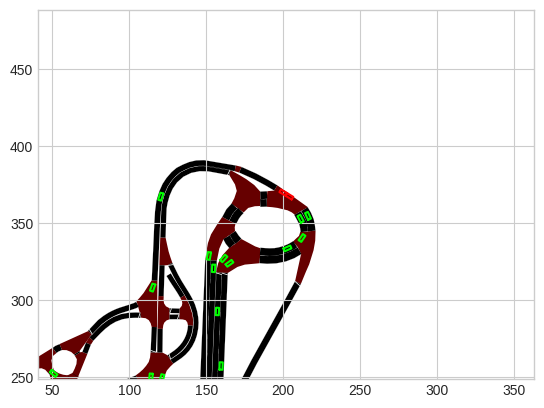

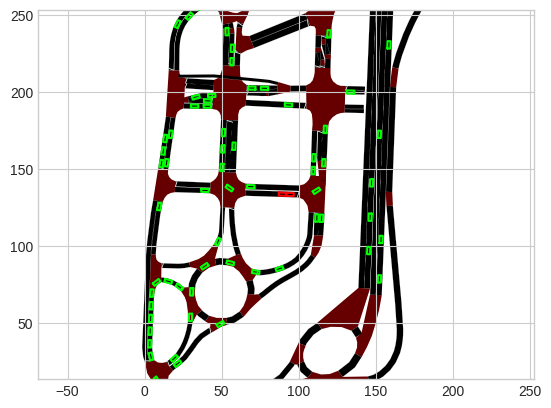

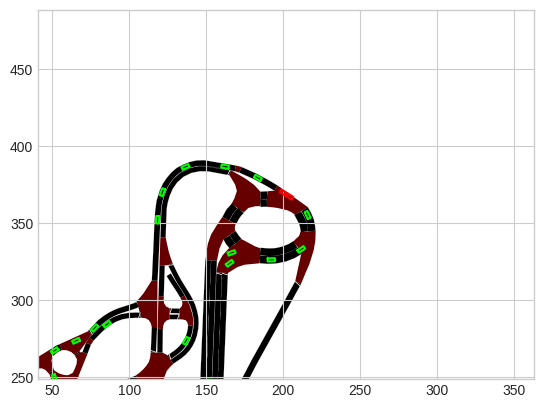

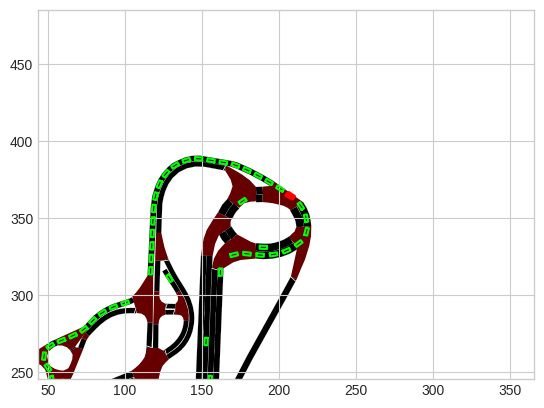

In [31]:
# 生成三个文件夹: simple(typical) non-negligence-caused negligence-caused 
export_path = f"{exp_repo}/{mode}/videos"
file_name = f"{export_stat_dir}/check_list.txt"

export_videos(f"{export_path}", non_neg_check_list_path)

### See README-viz.md for visualization

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout") & (exp_stats_info["lane_id"] == ":NODE_21_0_0") & (exp_stats_info["neg_info"] == "roundabout_neglect_conflict_lead")]["name"].values

array([], dtype=object)

In [109]:
exp_stats_info[(exp_stats_info["location"] == "roundabout")]["lane_id"].unique()

KeyError: 'location'